# Home Credit Default Risk - Introduction to Manual Feature Engineering

참고 : https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering

데이터파일 정의
- bureau : Home Credit에 보고된, 고객이 이전에 다른 금융기관에서 대출한 정보. 각 이전 대출금은 자체 행이 있다.
- bureau_balance : 이전 대출금에 대한 월별 정보. 각 달은 자체 행을 갖는다.

대출에 대한 도메인 지식이 제한되어있어 대신, 최종 train 데이터프레임이 가능한 많은 정보를 갖도록 한다. 어떤 변수가 중요한지 모델이 선택할 것이다. 기본적으로 가능한 많은 변수를 만들고 사용할 모델에 모두 입력하는 방법으로 접근한다. 나중에 모델의 변수 중요도나 PCA와 같은 기술을 사용해 변수를 축소할 수 있다.

수동 feature engineering은 많은 Pandas 코드와 약간의 인내심, 데이터 조작 연습을 필요로 한다. 자동 feature engineering도 사용 가능하지만 수동으로 진행해보자.

In [1]:
# 데이터 조작 위한 pandas, numpy
import pandas as pd
import numpy as np

# plotting 위한 matplotlib, seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# pandas로 경고 무시
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

# Example : Counts of a client's previous loans

수동 feature engineering의 일반적인 과정을 설명하기 위해, 먼저 다른 금융기관의 고객의 이전 대출 건수를 구한다. 이를 위해 많은 pandas 작업을 해야한다.
- groupby : 데이터프레임을 열로 그룹화한다. 이 경우 각 고객인 SK_ID_CURR열로 그룹화한다.
- agg : 열의 평균과 같이 그룹화된 데이터에 대해 계산한다. grouped_df.mean() 함수를 직접 호출하거나 agg 함수를 gropued_df.agg([mean,max,min,sum])과 같이 변환 목록과 함께 사용할 수 있다.
- merge : 집계(agg)된 통계를 적절한 고객과 일치시킨다. 원래 train 데이터와 SK_ID_CURR 열의 계산된 통계를 병합해 고객이 해당 통계를 갖지 않은 셀(결측행)에 NaN을 삽입한다.

딕셔너리로 이름을 변경할 열을 지정하는 rename 함수도 많이 사용한다. 생성한 새로운 변수를 찾는 데 유용하다.

In [2]:
bureau = pd.read_csv('../input/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [3]:
# 고객id(SK_ID_CURR)로 그룹화하고, 이전 대출금 건수를 세고, 열 이름을 변경한다.
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns={'SK_ID_BUREAU':'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [4]:
# train 데이터 join
train = pd.read_csv('../input/application_train.csv')
train = train.merge(previous_loan_counts, on='SK_ID_CURR', how='left')

# 결측값 0으로 대체
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,previous_loan_counts
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


스크롤을 오른쪽으로 돌리면 새로운 열을 볼 수 있다.

## Assessing Usefulness of New Variable with r value

새로운 변수가 유용한지 확인하기 위해 이 변수와 target간 피어슨 상관계수 (r값)을 계산할 수 있다. 이 값은 두 변수 사이의 선형 관계 강도와, -1(완벽한 음의 선형)부터 +1(완벽한 양의 선형)까지 범위를 측정한다. r값은 새로운 변수의 "유용도"에 대한 최적 척도는 아니지만, 기계학습 모델에 도움이 될지에 대해 첫 근사치를 제공한다. target에 대한 변수의 r값이 클수록 이 변수의 변화가 target값에 영향을 많이 미친다. 따라서 target값에 대한 r값의 절대값이 가장 큰 변수를 찾는다.

커널밀도추정(KDE) plot을 사용해 target과의 관계를 시각화할 수 있다.

### Kernel Density Estimate Plots

커널밀도추정 plot은 단일 변수의 분포가 표시된다(smoothed histogram과 같이). 범주에 따라 분포의 색을 다르게 지정해 범주형 변수 값에 따른 분포 차이를 확인할 수 있다. KDE 결과는 대출금을 상환하지 않은 사람(TARGET==1)과 상환한 사람(TARGET==0)간 변수 분포의 유의미한 차이를 보일 것이다. 이는 변수가 기계학습 모델과 "관련"있을지 나타내는 지표가 된다.

In [13]:
# target값에 따라 색이 지정된 변수의 분포 시각화

def kde_target(var_name, df):
    # 새 변수와 target간 상관계수 계산
    corr = df['TARGET'].corr(df[var_name])
    # target==0과 ==1의 중위수 계산
    avg_repaid = df.loc[df['TARGET']==0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET']==1, var_name].median()
    
    # KDE plot 시각화
    sns.kdeplot(df.loc[df['TARGET']==0,var_name], label='TARGET==0')
    sns.kdeplot(df.loc[df['TARGET']==1,var_name], label='TARGET==1')
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' %var_name)
    plt.legend()
    
    # 상관관계 출력
    print('The correlation between %s and the TARGET is %0.5f' %(var_name,corr))
    # 중위수 출력
    print('Median value for loan that was not repaid = %0.4f' %avg_not_repaid)
    print('Median value for loan that was repaid     = %0.4f' %avg_repaid)

Random Forest와 Gradient Boosting Machine에 따라 가장 중요한 변수 중 하나로 밝혀진 EXT_SOURCE_3 변수를 사용해 함수를 테스트해보자.

The correlation between EXT_SOURCE_3 and the TARGET is -0.17892
Median value for loan that was not repaid = 0.3791
Median value for loan that was repaid     = 0.5460


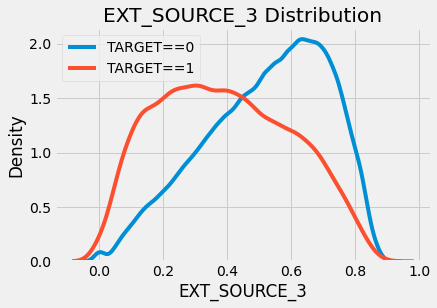

In [14]:
kde_target('EXT_SOURCE_3',train)

이제 방금 만든 새로운 변수에 대해, 다른 금융기관에서 이전에 대출한 건수를 확인해보자.

The correlation between previous_loan_counts and the TARGET is -0.01002
Median value for loan that was not repaid = 3.0000
Median value for loan that was repaid     = 4.0000


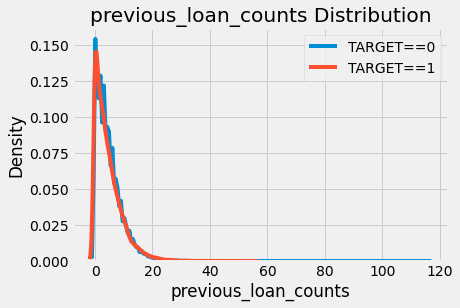

In [15]:
kde_target('previous_loan_counts', train)

이걸로 이 변수가 중요한지 알 수 없다. 상관계수가 매우 약하고 분포에 눈에 띄는 차이가 없다. bureau 데이터프레임에서 몇 가지 변수를 더 만들어보자. bureau 데이터프레임의 모든 수치 열의 평균, 최소, 최대값을 가져온다.

## Aggregating Numeric Columns

bureau 데이터프레임의 수치 정보를 설명하기 위해, 모든 수치 열에 대해 통계량을 계산한다. 고객id로 그룹화해, 그룹화된 데이터를 집계(agg)하고, train 데이터에서 결과를 병합한다. agg 함수는 연산이 유효한 숫자 열의 값만 계산할 수 있다. 'mean', 'max', 'min', 'sum'을 사용하지만 어떤 함수라도 들어갈 수 있다. 자체 함수를 작성하거나 agg를 호출해 사용할 수도 있다.

In [16]:
# id로 그룹화하고 집계 통계량 계산
bureau_agg = bureau.drop(columns=['SK_ID_BUREAU']).groupby('SK_ID_CURR',as_index=False).agg(['count','mean','max','min','sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                ... DAYS_CREDIT_UPDATE                               \
  mean max min  ...              count        mean  max   min   sum   
0  0.0   0   0  ...                  7  -93.142857   -6  -155  -652   
1  0.0   0   0  ...                  8 -499.875000   -7 -1185 -3999   
2  0.0   0   0  ...                  4 -816.000000  -43 -2131 -3264   
3  0.0   0   0  ...                  2 -532.000000 -382  -682 -1064   
4  0.0   0   0  ...                  3  -54.333333  -11  -121  -163   

  AMT_ANNUITY                                      
        count         mean      max  min      sum  
0           7  3545.357143  10822.5  0.0  24817.5  
1           7     0.000000      0.0  0.0      0.0  
2           0          NaN      NaN  NaN      0.0  
3           0          NaN      NaN  NaN      0.0  
4           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 61 columns]

이러한 각 열에 대해 새로운 이름을 생성한다. 다음 코드는 통계량에 이름을 추가해 새로운 이름을 만든다. 여기선 데이터프레임이 다중 인덱스가 있다는 것을 다뤄야한다. 이건 어려우므로 최대한 빨리 단일 인덱스로 줄인다.

In [18]:
columns = ['SK_ID_CURR']

for var in bureau_agg.columns.levels[0]:   # 변수 이름 반복
    if var != 'SK_ID_CURR' :
        for stat in bureau_agg.columns.levels[1][:-1]:  # 통계량 이름 반복
            columns.append('bureau_%s_%s' %(var,stat))  # 변수와 통계량에 새 이름 생성

In [19]:
# 데이터프레임 열 이름으로 열 이름 리스트 할당
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


이제 위에서 한 것과 train 데이터를 간단히 합쳐보자.

In [20]:
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,8.0,-499.875,-7.0,-1185.0,-3999.0,7.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,4.0,-816.000,-43.0,-2131.0,-3264.0,0.0,NaN,NaN,NaN,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,2.0,-532.000,-382.0,-682.0,-1064.0,0.0,NaN,NaN,NaN,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,1.0,-783.000,-783.0,-783.0,-783.0,0.0,NaN,NaN,NaN,0.0


### Correlations of Aggregated Values with Target

모든 새로운 변수와 target의 상관관계를 계산해보자. 모델링에 중요할 수 있는 변수의 근사치로 사용할 수 있다.

In [21]:
new_corrs = []
for col in columns:
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))

아래 코드는 sorted 함수를 사용해 상관관계를 크기(절대값)별로 정렬한다. 또 다른 중요한 파이썬 작업인 lambda 함수를 사용한다.

In [23]:
# 절대값으로 상관관계 정렬
# 리스트 맨 앞이 가장 큰 값이려면 reverse해야함
new_corrs = sorted(new_corrs, key=lambda x: abs(x[1]), reverse=True)
new_corrs[:15]

[('bureau_DAYS_CREDIT_mean', 0.089728967219981),
 ('bureau_DAYS_CREDIT_min', 0.07524825103010374),
 ('bureau_DAYS_CREDIT_UPDATE_mean', 0.06892735266968684),
 ('bureau_DAYS_ENDDATE_FACT_min', 0.055887379843920795),
 ('bureau_DAYS_CREDIT_ENDDATE_sum', 0.053734895601020585),
 ('bureau_DAYS_ENDDATE_FACT_mean', 0.05319962585758622),
 ('bureau_DAYS_CREDIT_max', 0.04978205463997309),
 ('bureau_DAYS_ENDDATE_FACT_sum', 0.048853502611115936),
 ('bureau_DAYS_CREDIT_ENDDATE_mean', 0.04698275433483553),
 ('bureau_DAYS_CREDIT_UPDATE_min', 0.04286392247073023),
 ('bureau_DAYS_CREDIT_sum', 0.04199982481484667),
 ('bureau_DAYS_CREDIT_UPDATE_sum', 0.0414036353530601),
 ('bureau_DAYS_CREDIT_ENDDATE_max', 0.03658963469632898),
 ('bureau_DAYS_CREDIT_ENDDATE_min', 0.034281109921615996),
 ('bureau_DAYS_ENDDATE_FACT_count', -0.03049230665332547)]

어떤 새로운 변수도 TARGET과 유의한 상관관계를 갖지 않는다. 가장 상관관계가 높은 변수인 bureau_DAYS_CREDIT_mean의 KDE plot을 절대값 크기의 상관관계 측면에서 살펴보자.

The correlation between bureau_DAYS_CREDIT_mean and the TARGET is 0.08973
Median value for loan that was not repaid = -835.3333
Median value for loan that was repaid     = -1067.0000


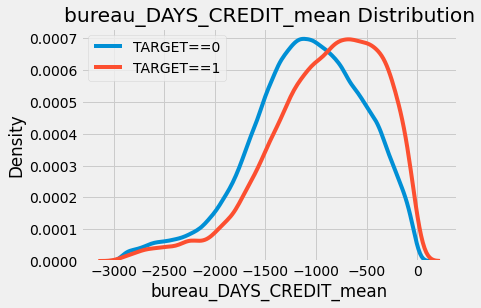

In [24]:
kde_target('bureau_DAYS_CREDIT_mean', train)

이 열의 정의는 "현재 신청 고객이 Credit Bureau 신용을 신청하기 며칠 전인지"를 나타낸다. 이전에 Home Credit에서 대출금을 신청하기 전 이전 대출금이 신청된 일수라고 해석할 수 있다. 따라서 음수가 클수록 현재 대출금 신청 이전에 대출금이 오래됐다는 것을 나타낸다. 이 변수의 평균과 target의 매우 약한 양의 상관관계를 보았는데, 이는 아주 과거에 대출금을 신청했던 고객이 Home Credit에서 대출금을 상환할 가능성이 잠재적으로 더 높다는 것을 의미한다. 하지만 이 약한 상관관계는 노이즈일 가능성이 있다.

#### The Multiple Comparisons Problems

변수가 많을 때 일부 변수는 우연에 의해 상관관계가 있을 거라고 예상하는데, 이는 다중비교 문제다. 수백개의 변수를 만들면, 일부는 단순히 데이터의 랜덤 노이즈 때문에 target과 상관관계가 있을 수 있다. 그러고 모델을 학습시킬 때, train 데이터셋의 target과 관계가 있다고 생각하기 때문에 변수의 과적합될 수 있지만, test 데이터셋에 꼭 일반화되진 않는다. 변수를 만들 때 고려해야할 사항이 많다. 

## Function for Numeric Aggregations

이전 작업을 모두 함수로 캡슐화해보자. 이를 통해 데이터프레임의 숫자 열에 대한 집계 통계를 계산할 수 있다. 다른 데이터프레임에 같은 작업을 하고싶을 때 이 함수를 재사용할 수 있다.

In [38]:
def agg_numeric(df, group_var, df_name):
    """
    데이터프레임의 수치값을 집계한다. 
    그룹화된 변수의 각 인스턴스에 대해 변수를 생성할 수 있다.
    
    파라미터
    ---------
        df (dataframe) : 통계량을 계산할 데이터프레임
        group_var (string) : 그룹화된 데이터프레임의 변수
        df_name (string) : 이름을 바꿀 변수
    반환값
    --------
        agg (dataframe) : 모든 숫자 열에 대해 집계된 통계 데이터프레임
            그룹화 변수의 각 인스턴스는 통계량(mean,min,max,sum)이 계산됨
            생성된 변수를 찾기 위해 열 이름이 변경됨
    """
    
    # 그룹화 변수가 아닌 id 변수 제거
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns=col)
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
        
    # 지정된 변수로 그룹화하고 통계량 계산
    agg = numeric_df.groupby(group_var).agg(['count','mean','max','min','sum']).reset_index()
    # 새로운 열 이름 생성
    columns = [group_var]
    
    for var in agg.columns.levels[0]:  # 변수 이름 반복
        if var != group_var :  # 그룹화변수 무시
            for stat in agg.columns.levels[1][:-1]:  # 통계량 이름 반복
                columns.append('%s_%s_%s' %(df_name,var,stat))  # 변수와 통계량으로 새 이름 생성
    agg.columns = columns
    return agg

In [39]:
bureau_agg_new = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR',df_name='bureau')
bureau_agg_new.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


직접 만든 집계 데이터프레임과 비교해보자.

In [40]:
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


위의 두 개가 같다. 다른 데이터프레임의 수치 통계를 계산하는 데 이 함수를 재사용할 수 있다. 함수를 사용하는 건 일관된 결과를 얻을 수 있고 일의 양을 줄일 수 있다.

### Correlation Function

target과 상관관계를 계산하는 코드를 함수로 만들 수도 있다.

In [41]:
def target_corrs(df):
    corrs = []
    for col in df.columns:  # 열 반복
        print(col)
        if col != 'TARGET':
            corr = df['TARGET'].corr(df[col])  # target과 상관관계 계산
            corrs.append((col,corr))  # 튜플로 리스트에 저장
    corrs = sorted(corrs,key=lambda x:abs(x[1]),reverse=True)  # 상관관계 절대값 크기로 정렬
    return corrs

## Categorical Variables

이제 숫자 열에서 범주형 열로 넘어가자. 이산형 문자열 변수이므로 수치변수에서 작동하는 mean, max와 같은 통계량을 계산할 수 없다. 대신, 각 범주형 변수에서 각 범주값의 수를 계산할 수 있다. 

우선, 범주형 변수(dtype=='object')에 대해서만 데이터프레임을 one-hot encoding한다.

In [43]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan,SK_ID_CURR
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,215354


In [63]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum','mean'])
categorical_grouped.head()

CREDIT_ACTIVE_Active           CREDIT_ACTIVE_Bad debt       \
                            sum      mean                    sum mean   
SK_ID_CURR                                                              
100001                        3  0.428571                      0  0.0   
100002                        2  0.250000                      0  0.0   
100003                        1  0.250000                      0  0.0   
100004                        0  0.000000                      0  0.0   
100005                        2  0.666667                      0  0.0   

           CREDIT_ACTIVE_Closed           CREDIT_ACTIVE_Sold       \
                            sum      mean                sum mean   
SK_ID_CURR                                                          
100001                        4  0.571429                  0  0.0   
100002                        6  0.750000                  0  0.0   
100003                        3  0.750000                  0  0.0   
100004                        2  1.000000                  0  0.0   
100005                        1  0.333333                  0  0.0   

           CREDIT_CURRENCY_currency 1       ... CREDIT_TYPE_Microloan       \
                                  sum mean  ...                   sum mean   
SK_ID_CURR                                  ...                              
100001                              7  1.0  ...                     0  0.0   
100002                              8  1.0  ...                     0  0.0   
100003                              4  1.0  ...                     0  0.0   
100004                              2  1.0  ...                     0  0.0   
100005                              3  1.0  ...                     0  0.0   

           CREDIT_TYPE_Mobile operator loan      CREDIT_TYPE_Mortgage       \
                                        sum mean                  sum mean   
SK_ID_CURR                                                                   
100001                                    0  0.0                    0  0.0   
100002                                    0  0.0                    0  0.0   
100003                                    0  0.0                    0  0.0   
100004                                    0  0.0                    0  0.0   
100005                                    0  0.0                    0  0.0   

           CREDIT_TYPE_Real estate loan      CREDIT_TYPE_Unknown type of loan  \
                                    sum mean                              sum   
SK_ID_CURR                                                                      
100001                                0  0.0                                0   
100002                                0  0.0                                0   
100003                                0  0.0                                0   
100004                                0  0.0                                0   
100005                                0  0.0                                0   

                 
           mean  
SK_ID_CURR       
100001      0.0  
100002      0.0  
100003      0.0  
100004      0.0  
100005      0.0  

[5 rows x 46 columns]

sum 열은 관련 고객의 범주 수를, mean은 정규화된 count를 나타낸다. one-hot encoding을 사용하면 이런 값을 쉽게 계산할 수 있다.

이전과 비슷한 함수를 사용해 열 이름을 바꿀 수 있다. 열의 다중 인덱스를 다시 다뤄야한다. (one-hot encoding에서) 범주값을 추가한 범주형 변수의 이름인 첫 level(level 0)을 반복한다. 그리고 각 고객에 대해 계산한 통계량을 반복한다. 통계량이 추가된 level 0 이름으로 열 이름을 변경한다. 예시로 CREDIT_ACTE_Active 열은 level 0이고, CREDIT_ACTIVE_Active_count는 level 1인 sum이다.

In [64]:
categorical_grouped.columns.levels[0][:10]

Index(['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt',
       'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold',
       'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2',
       'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4',
       'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan'],
      dtype='object')

In [48]:
categorical_grouped.columns.levels[1]

Index(['sum', 'mean'], dtype='object')

In [65]:
group_var = 'SK_ID_CURR'
columns = []
for var in categorical_grouped.columns.levels[0]:
    if var != group_var:
        for stat in ['count','count_norm'] :  # 통계량 이름 반복
            columns.append('%s_%s' %(var,stat))  # 변수와 통계량으로 새 이름 생성
categorical_grouped.columns = columns
categorical_grouped.head()

,CREDIT_ACTIVE_Active_count,CREDIT_ACTIVE_Active_count_norm,CREDIT_ACTIVE_Bad debt_count,CREDIT_ACTIVE_Bad debt_count_norm,CREDIT_ACTIVE_Closed_count,CREDIT_ACTIVE_Closed_count_norm,CREDIT_ACTIVE_Sold_count,CREDIT_ACTIVE_Sold_count_norm,CREDIT_CURRENCY_currency 1_count,CREDIT_CURRENCY_currency 1_count_norm,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


sum 열은 count를, mean 열은 정규화된 count를 나타낸다.

이 데이터 프레임을 train 데이터에 병합할 수 있다.

In [66]:
train = train.merge(categorical_grouped, left_on='SK_ID_CURR', right_index=True, how='left')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
train.shape

(307511, 229)

In [68]:
train.iloc[:10,123:]

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,CREDIT_TYPE_Microloan_count,CREDIT_TYPE_Microloan_count_norm,CREDIT_TYPE_Mobile operator loan_count,CREDIT_TYPE_Mobile operator loan_count_norm,CREDIT_TYPE_Mortgage_count,CREDIT_TYPE_Mortgage_count_norm,CREDIT_TYPE_Real estate loan_count,CREDIT_TYPE_Real estate loan_count_norm,CREDIT_TYPE_Unknown type of loan_count,CREDIT_TYPE_Unknown type of loan_count_norm
0,8.0,-874.000000,-103.0,-1437.0,-6992.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,-1400.750000,-606.0,-2586.0,-5603.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,-867.000000,-408.0,-1326.0,-1734.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,-1149.000000,-1149.0,-1149.0,-1149.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3.0,-757.333333,-78.0,-1097.0,-2272.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,18.0,-1271.500000,-239.0,-2882.0,-22887.0,18.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.0,-1939.500000,-1138.0,-2741.0,-3879.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,-1773.000000,-1309.0,-2508.0,-7092.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Function to Handle Categorical Variables

효율적인 코드를 만들기 위해, 범주형 변수를 처리하는 함수를 만들 수 있다. 데이터프레임과 그룹화 변수를 사용한다는 점에서 agg_numeric 함수와 동일한 형식이다. 그리고 데이터프레임의 모든 범주형 변수의 각 범주의 count와 정규화된 count를 계산한다.

In [71]:
def count_categorical(df, group_var, df_name):
    """
    모든 범주형 변수에서 각 고유 범주의 'group_var'의 각 관측치에 대한
    count와 정규화된 count 계산
    
    파라미터
    ---------
    df (dataframe) : count를 계산할 데이터프레임
    group_var (string) : 그룹화할 데이터프레임의 변수.
        이 변수의 각 고유값에서, 최종 데이터프레임은 한 행을 갖는다.
    df_name (string) : 열을 찾기 위해 열 이름 앞에 추가된 변수
    
    반환
    --------
    categorical (dataframe) : 'gropu_var'의 모든 고유값에 대해 한 행이 있는
        모든 범주형 변수의 각 고유 범주의 count와 정규화된 count를 가진 데이터프레임
    """
    
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]  # 열에 id를 입력해야함
    categorical = categorical.groupby(group_var).agg(['sum','mean'])
    
    column_names = []
    for var in categorical.columns.levels[0]:  # level0인 열 반복
        for stat in ['count','count_norm']:  # level1인 통계량 반복
            column_names.append('%s_%s_%s' %(df_name,var,stat))  # 새로운 열이름
    categorical.columns = column_names
    
    return categorical

In [72]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR', df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Applying Operations to another dataframe

이제 bureau balance 데이터프레임으로 넘어가보자. 이 데이터프레임은 각 고객의 다른 금융기간에서의 이전 대출금에 대한 월별 정보가 있다. 고객id인 SK_ID_CURR로 그룹화하는 대신,우선 이전 대출금 id인 SK_ID_BUREAU로 데이터프레임을 그룹화한다. 각 대출금에 대해 한 행의 데이터프레임을 줄 것이다. 그러면 SK_ID_CURR로 그룹화해 각 고객의 대출금의 집계를 계산할 수 있다. 최종 결과는 각 고객에 대해 대출금이 통계량으로 계산된 한 행인 데이터프레임이다.

In [73]:
bureau_balance = pd.read_csv('../input/bureau_balance.csv')
bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


우선 각 대출금에 대한 각 통계량의 count를 계산할 수 있다. 위에서 이걸 계산하는 함수를 갖고있다.

In [74]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


이제 숫자 열 하나를 처리할 수 있다. MONTHS_BALANCE 열은 "신청일 대비 잔액 월"이다. 이는 숫자 변수로써 중요하지 않을 수도 있고, 나중에 이것을 시간 변수로 간주할 수 있다. 지금은 전처럼 동일한 집계통계량을 계산해보자.

In [76]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


위의 데이터프레임은 각 대출금에 대해 계산한 것이다. 이제 각 고객별로 집계해야한다. 데이터프레임을 먼저 병합하고 모든 변수가 숫자면 이번엔 SK_ID_CURR로 그룹화해 통계를 다시 집계한다.

In [77]:
# 대출금으로 그룹화
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')
# SK_ID_CURR 포함 병합
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU','SK_ID_CURR']], on='SK_ID_BUREAU', how='left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,...,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.0,0,-96,-4656,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402,NaN
1,5001710,83,-41.0,0,-82,-3403,5,0.060241,0,0.0,...,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446,162368.0
2,5001711,4,-1.5,0,-3,-6,3,0.750000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000,162368.0
3,5001712,19,-9.0,0,-18,-171,10,0.526316,0,0.0,...,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000,162368.0
4,5001713,22,-10.5,0,-21,-231,0,0.000000,0,0.0,...,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000,150635.0


In [78]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']),group_var='SK_ID_CURR',df_name='client')
bureau_balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,...,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,...,7,4.285714,9,0,30.0,7,0.214590,0.500000,0.0,1.502129
1,100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,...,8,1.875000,3,0,15.0,8,0.161932,0.500000,0.0,1.295455
2,100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,...,3,0.666667,1,0,2.0,3,0.136752,0.333333,0.0,0.410256
3,100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,...,2,0.000000,0,0,0.0,2,0.000000,0.000000,0.0,0.000000
4,100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,...,4,10.250000,40,0,41.0,4,0.254545,1.000000,0.0,1.018182


bureau_balance 데이터프레임을 요약하면 다음과 같다.
1. 각 대출별 수치 통계량 계산
2. 각 대출별 범주형 변수의 값 count
3. 대출에 대한 통계량과 값 count 병합
4. 고객 id별 결과 데이터프레임에 대한 수치 통계량 계산

최종 데이터프레임은 각 고객에 대해 한 행이 있고, 월별 잔액 정보를 통해 모든 대출에 대해 계산된 통계량이 있다. 몇 가지 변수를 설명해보자면,
- client_bureau_balance_MONTHS_BALANCE_mean_mean : 각 대출금에 대해 MONTHS_BALANCES의 평균값 계산
- client_bureau_balance_STATUS_X_count_norm_sum : 각 대출금에 대해, STATUS==X 발생횟수를 대출금에 대해 총 STATUS값으로 나누고, 각 고객에 대해 각 대출금 값을 합한 값.

모든 변수가 하나의 데이터프레임에 있을 때까지 상관관계 계산을 미룬다.

# Putting the Functions Together

이제 다른 금융기관의 이전 대출과 이런 대출에 대한 월별 지급 정보를 받아, train 데이터프레임에 넣을 수 있는 모든 자료를 준비했다. 모든 변수를 다시 설정하고 만든 변수를 사용해 처음부터 다시 설정해보자. 반복가능한 함수를 사용하는 것의 이점을 볼 수 있다.

In [149]:
# 이전 객체 삭제해 메모리 초기화
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

5754

In [150]:
# 데이터프레임 다시 불러오기
train = pd.read_csv('../input/application_train.csv')
bureau = pd.read_csv('../input/bureau.csv')
bureau_balance = pd.read_csv('../input/bureau_balance.csv')

### Counts of Bureau Dataframe

In [81]:
bureau_counts = count_categorical(bureau, group_var='SK_ID_CURR',df_name='bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


### Aggregated Stats of Bureau Dataframe

In [82]:
bureau_agg = agg_numeric(bureau.drop(columns=['SK_ID_BUREAU']),group_var='SK_ID_CURR',df_name='bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Value counts of Bureau Balance dataframe by loan

In [83]:
bureau_balance_counts = count_categorical(bureau_balance, group_var='SK_ID_BUREAU', df_name='bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


### Aggregated stats of Bureau Balance dataframe by loan

In [84]:
bureau_balance_agg = agg_numeric(bureau_balance,group_var='SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


### Aggregated Stats of Bureau Balance by Client

In [87]:
# 대출로 그룹화
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True, left_on='SK_ID_BUREAU', how='outer')
# SK_ID_CURR 포함 병합
bureau_by_loan = bureau[['SK_ID_BUREAU','SK_ID_CURR']].merge(bureau_by_loan, on='SK_ID_BUREAU',how='left')

# 각 고객에 대해 통계량 집계
bureau_balanace_by_client = agg_numeric(bureau_by_loan.drop(columns=['SK_ID_BUREAU']), group_var='SK_ID_CURR', df_name='client')

## Insert Computed Features into Training Data

In [88]:
original_features = list(train.columns)
print('Original Number of Features:',len(original_features))

Original Number of Features: 122


In [89]:
# bureau 값 count 병합
train = train.merge(bureau_counts, on='SK_ID_CURR', how='left')
# bureau 통계량 병합
train = train.merge(bureau_agg, on='SK_ID_CURR', how='left')
# 고객으로 그룹화한 월별 정보 병합
train = train.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

In [90]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  333


# Feature Engineering Outcomes

이 모든 작업이 끝난 후, 이제 우리가 만든 변수를 살펴보려고 한다. 결측값의 백분율, 변수와 target값의 상관관계, 변수간 상관관계를 볼 수 있다. 변수간 상관관계는 선형변수, 즉 서로 높은 상관관계를 갖는 변수를 보여준다. 가끔, 두 변수가 중복되어 한 쌍의 선형변수에서 하나를 제거한다. 또한 결측값의 백분율을 사용해 대부분의 값이 없는 변수를 제거할 수 있다. 변수의 수를 줄이면 모델이 train 데이터를 학습하고 test데이터에 대해 더 잘 일반화할 수 있기 때문에 변수선택은 중요하다. "차원의 저주"는 너무 변수가 많아(차원이 높아) 발생하는 문제다. 변수의 수가 증가하면, 이런 변수와 target값의 관계를 더 많이 학습해야한다.

변수선택은 모델이 test 데이터셋을 더 잘 학습하고 일반화하도록 돕기 위해 변수를 제거하는 과정이다. 목표는 쓸모없거나 중복인 변수를 제거하는 동시에 유용한 변수를 유지하는 것이다. 여기선 결측값의 비율이 높은 열과 상관관계가 높은 변수를 제거하는 작업을 한다. Gradient Boosting Machine과 Random Forest와 같은 모델에서 반환되는 변수 중요도를 사용해 변수선택을 할 수 있다.

## Missing Values

데이터프레임에 결측값이 있다. 결측값이 너무 많은 열은 삭제해야 할 수 있다.

In [91]:
# 각 열의 결측값 계산하는 함수

def missing_values_table(df):
    mis_val = df.isnull().sum()  # 총 결측값
    mis_val_percent = 100*df.isnull().sum() / len(df)  # 결측값 비율
    mis_val_table = pd.concat([mis_val,mis_val_percent],axis=1)  # 결과표
    
    mis_val_table_ren_columns = mis_val_table.rename(          # 열 이름 변경
        columns={0:'Missing Values', 1:'% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[      # 결측비율로 
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(  # 내림차순 정렬
        '% of Total Values', ascending=False).round(1)
    
    print('Your selected dataframe has ' + str(df.shape[1]) + 'columns.\n'
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
         ' columns that have missing values.')
    
    return mis_val_table_ren_columns

In [92]:
missing_train = missing_values_table(train)
missing_train.head(10)

Your selected dataframe has 333columns.
There are 278 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_min,215280,70.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0


결측값 비율이 높은 열이 여러 개다. 결측값을 제거하기 위한 잘 설정된 임계값이 없고, 최선의 방법은 문제에 따라 다르다. 여기선, 결측값이 90% 이상인 train, test 데이터의 열을 모두 제거해 변수의 수를 줄인다.

In [93]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values']>90])
len(missing_train_vars)

0

결측값을 제거하기 전 test 데이터에서 결측값 백분율을 확인할 수 있다. 그리고 train, test 데이터에서 결측값이 90% 이상인 열을 제거한다. test 데이터를 불러와 동일한 작업을 수행하고 test 데이터의 결측값을 살펴보자. 이미 모든 count와 집계 통계량을 계산했으므로 test 데이터만 적절한 데이터와 병합하면 된다.

## Calculate Information for Testing Data

In [94]:
test = pd.read_csv('../input/application_test.csv')
test = test.merge(bureau_counts, on='SK_ID_CURR', how='left')  # count로 병합
test = test.merge(bureau_agg, on='SK_ID_CURR', how='left')     # 통계량으로 병합
test = test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left') # 잔액 count로 병합

In [95]:
print('Shape of Testing Data :', test.shape)

Shape of Testing Data : (48744, 332)


test, train 데이터프레임을 열이 정확히 일치하도록 정렬해야한다. 변수를 one-hot encoding 할 때 데이터프레임이 동일한 열을 가지도록 정렬되어야한다.

In [96]:
train_labels = train['TARGET']
tain, test = train.align(test,join='inner',axis=1)  # 정렬하면 TARGET 삭제
train['TARGET'] = train_labels

In [97]:
print('Training Data Shape :', train.shape)
print('Testing Data Shape :', test.shape)

Training Data Shape : (307511, 333)
Testing Data Shape : (48744, 332)


이제 데이터프레임에 동일한 열이 있다(train 데이터의 TARGET 열 제외). train, test 데이터프레임에서 모두 동일한 열을 취해야하는 기계학습 모델에서 유용하다. 

삭제해야할 열을 파악하도록 test 데이터에서 결측값의 백분율을 살펴보자.

In [98]:
missing_test = missing_values_table(test)
missing_test.head(10)

Your selected dataframe has 332columns.
There are 275 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_AVG,33495,68.7
NONLIVINGAPARTMENTS_MEDI,33347,68.4
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MEDI,32780,67.2
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2


In [99]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values']>90])
len(missing_test_vars)

0

In [100]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

There are 0 columns with more than 90% missing in either the training or testing data.


In [101]:
# 결측값 삭제
train = train.drop(columns=missing_columns)
test = test.drop(columns=missing_columns)

결측값이 90% 이상인 열이 없어 열을 제거하지 못했다. 차원 축소를 위해 다른 변수선택 방법을 적용해야할 수 있다.

이 시점에서 train, test 데이터를 모두 저장한다. 누락된 열을 삭제하고 결과를 비교하기 위해 다른 비율로 시도해볼 것을 권한다.

In [102]:
train.to_csv('train_bureau_raw.csv', index = False)
test.to_csv('test_bureau_raw.csv', index = False)

## Correlations

먼저 변수와 target의 상관관계를 알아보자. 생성된 변수 중 어떤 변수라도 train 데이터에 이미 있는 변수보다 더 큰 상관관계가 있음을 알 수 있다.

In [104]:
# 데이터프레임의 모든 상관관계 계산
corrs = train.corr()

In [108]:
corrs = corrs.sort_values('TARGET', ascending=False)
pd.DataFrame(corrs['TARGET'].head(10))  # 양의 상관관계 큰 것부터 10개 정렬

,TARGET
TARGET,1.000000
bureau_DAYS_CREDIT_mean,0.089729
client_bureau_balance_MONTHS_BALANCE_min_mean,0.089038
DAYS_BIRTH,0.078239
bureau_CREDIT_ACTIVE_Active_count_norm,0.077356
client_bureau_balance_MONTHS_BALANCE_mean_mean,0.076424
bureau_DAYS_CREDIT_min,0.075248
client_bureau_balance_MONTHS_BALANCE_min_min,0.073225
client_bureau_balance_MONTHS_BALANCE_sum_mean,0.072606
bureau_DAYS_CREDIT_UPDATE_mean,0.068927


In [107]:
# 음의 상관관계 큰 것 10개
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
client_bureau_balance_MONTHS_BALANCE_count_min,-0.048224
client_bureau_balance_STATUS_C_count_norm_mean,-0.055936
client_bureau_balance_STATUS_C_count_max,-0.061083
client_bureau_balance_STATUS_C_count_mean,-0.062954
client_bureau_balance_MONTHS_BALANCE_count_max,-0.068792
bureau_CREDIT_ACTIVE_Closed_count_norm,-0.079369
client_bureau_balance_MONTHS_BALANCE_count_mean,-0.080193
EXT_SOURCE_1,-0.155317
EXT_SOURCE_2,-0.160472
EXT_SOURCE_3,-0.178919


target과 상관관계가 가장 높은 변수(물론 1인 TARGET 이외 변수)는 생성한 변수다. 그러나 상관관계가 있다고 해서 유용하다는 의미는 아니며, 수백 개의 새로운 변수를 생성하면 일부는 단순 무작위 노이즈 때문에 target과 상관관계가 있다.

상관관계를 회의적으로 보면 생성된 변수 중 몇 개는 유용할지도 모른다. 변수의 "유용성"을 평가하기 위해 모델이 반환하는 변수 중요도에 대해 알아보자. 새로 생성된 변수 중 두 개의 kde plot을 그린다.

The correlation between client_bureau_balance_MONTHS_BALANCE_count_mean and the TARGET is -0.08019
Median value for loan that was not repaid = 19.3333
Median value for loan that was repaid     = 25.1429


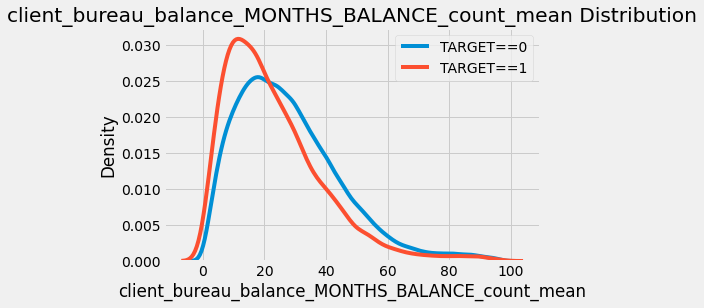

In [112]:
kde_target(var_name='client_bureau_balance_MONTHS_BALANCE_count_mean', df=train)

이 변수는 각 고객의 대출당 월 평균 레코드 수를 나타낸다. 예를 들어 고객이 월별 데이터에 세 개의 이전 대출금 3,4,5 레코드가 있으면, 이 변수의 값은 4가 된다. 분포를 보면 대출당 월평균 레코드 수가 많은 고객은 Home Credit에서 대출금을 상환할 가능성이 높다. 이전 신용 내역이 많은 고객일수록 일반적으로 대출금을 상환할 가능성이 높다는 것을 나타낸다.

The correlation between bureau_CREDIT_ACTIVE_Active_count_norm and the TARGET is 0.07736
Median value for loan that was not repaid = 0.5000
Median value for loan that was repaid     = 0.3636


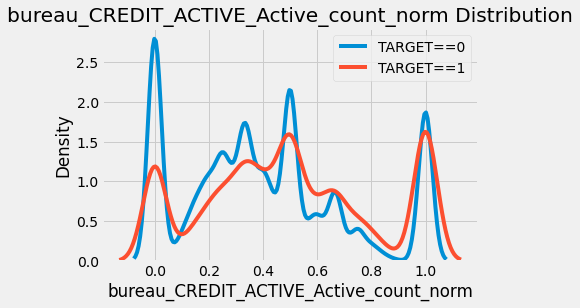

In [110]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

이 분포는 사방에 널려있다. 이 변수는 CREDIT_ACTIVE값이 Active인 이전 대출 건수를 고객의 이전 대출 건수로 나눈 값이다. 상관관계가 너무 약해 결론을 내릴 수 없다.

### Collinear Variabels

변수와 target의 상관관계뿐 아니라 변수간 상관관계도 계산할 수 있다. 이를 통해 데이터에서 제거해야할 선형관계가 높은 변수가 있는지 확인한다. 

다른 변수와 0.8 이상의 상관관계를 갖는 변수를 살펴보자.

In [113]:
threshold = 0.8  # 임계값 설정
above_threshold_vars = {}  # 상관관계가 있는 변수를 담을 빈 딕셔너리
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col]>threshold])

상관관계가 높은 각 변수 쌍에 대해 한 변수만 제거하려고 한다. 다음 코드는 각 쌍 중 하나만 추가해 제거할 변수 집합을 만든다.

In [114]:
# 제거할 열 탐색 및 이미 검사된 열
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key,value in above_threshold_vars.items():  # 열과 상관관계 높은 열 반복
    # 이미 검사된 열 탐색
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else :
            # 한 쌍에서 하나만 삭제
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove :', len(cols_to_remove))

Number of columns to remove : 134


train, test 데이터셋에서 모두 이런 열을 제거할 수 있다. 이러한 변수를 제거한 후 성능을 비교해야한다.

In [116]:
train_corrs_removed = train.drop(columns=cols_to_remove)
test_corrs_removed = test.drop(columns=cols_to_remove)

print('Training Corrs Removed Shape :', train_corrs_removed.shape)
print('Testing Corrs Removed Shape :', test_corrs_removed.shape)

Training Corrs Removed Shape : (307511, 199)
Testing Corrs Removed Shape : (48744, 198)


In [117]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

# Modeling

새로운 데이터셋의 성능을 테스트하기 위해 기계학습에 데이터셋을 사용해보자. 모든 데이터셋에 대해 아래 모델을 사용한다.(정확한 하이퍼파라미터와 함께)
- control : application 파일의 데이터만
- test one : bureau와 bureau_balance 파일의 모든 데이터와 함께 application 파일의 데이터
- test two : 삭제된 변수와 상관관계까 높은, bureau와 bureau_balance 파일의 모든 데이터와 함께 application 파일의 데이터 

In [118]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt

In [155]:
def model(features, test_features, encoding='ohe'):
    """
    light gradient boosting model 학습 및 교차검증을 사용해 테스트
    
    파라미터
    ----------
        features (pd.DataFrame) : 모델을 학습시키는 데 사용하는 train 변수의
            TARGET을 포함한 데이터프레임
        test_features (pd.DataFrame) : 모델에서 예측하는 데 사용하는
            test 변수의 데이터프레임
        encoding (str, default='ohe') : 범주형 변수 인코딩 방법.
            'ohe'는 원핫인코딩, 'le'는 라벨인코딩.
        n_folds (int, default=5) : 교차검증에 사용되는 fold 수
        
    return
    ----------
    submission (pd.DataFrame) : 모델에서 예측된 'SK_ID_CUUR'과 'TARGET'의 확률
    feature_importances (pd.DataFrame) : 모델에서 나온 변수중요도
    valid_metrics (pd.DataFrame) : 각 fold와 전체적인 train, validation
        지표 (ROC AUC)
    """
    
    train_ids = features['SK_ID_CURR']       # id 추출
    test_ids = test_features['SK_ID_CURR']
    labels = features['TARGET']  # train에서 target 추출
    
    features = features.drop(columns=['SK_ID_CURR','TARGET'])  # id, target 삭제
    test_features = test_features.drop(columns=['SK_ID_CURR'])
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # 데이터프레임을 열로 정렬
        features, test_features = features.align(test_features, join='inner', axis=1)
        # 레코드에 범주형 인덱스 없게
        cat_indices = 'auto'
    
    # Label Encoding
    elif encoding == 'le':
        Label_encoder = LabelEncoder()  # label encoder 생성
        cat_indices = []
        
        for i,col in enumerate(features):  # 각 열 반복
            if features[col].dtype == 'object':
                # 범주형 변수를 정수로 매핑
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))
                cat_indices.append(i)  # 범주형 인덱스 추가
            
        
    # label encoding 유효하지 않으면 에러 표시
    else :
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    #------------------------------------------------------
    
    feature_names = list(features.columns)  # 변수이름 추출
    features = np.array(features)  # np array로 변경
    test_features = np.array(test_features)
    
    k_fold = KFold(shuffle=True, random_state=50) ### n_splits = n_folds 생략
    feature_importance_values = np.zeros(len(feature_names))  # 변수중요도 빈 array로 저장
    test_predictions = np.zeros(test_features.shape[0])  # test 예측 위한 빈 array
    out_of_fold = np.zeros(features.shape[0])  # validation 예측 위한 빈 array
    
    valid_scores = []
    train_scores = []
    
    for train_indices, valid_indices in k_fold.split(features):  # 각 폴드 반복
        # 각 폴드의 train, validation 데이터
        train_features, train_labels = features[train_indices], labels[train_indices]
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # 모델 생성
        model = lgb.LGBMClassifier(n_estimators=10000,objective = 'binary', class_weight='balanced',
                                  learning_rate=0.05,reg_alpha=0.1,reg_lambda=0.1,subsample=0.8,random_state=50)
        # 모델 학습
        model.fit(train_features, train_labels,eval_metric='auc',
                 eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                 eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                 early_stopping_rounds = 100, verbose = 200)
        
        best_iteration = model.best_iteration_  # 최적 반복
        feature_importance_values += model.feature_importances_ / k_fold.n_splits  # 변수중요도
        
        # 예측 생성
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        # 폴드 예측 기록
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        # 최고 점수 기록
        valid_score = model.best_score_['valid']['auc']  
        train_score = model.best_score_['train']['auc']
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # 메모리 초기화
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})  # 제출 데이터프레임
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})  # 변수중요도 데이터프레임
    
    valid_auc = roc_auc_score(labels, out_of_fold)  # 전체 validation 점수
    valid_scores.append(valid_auc)  # 전체적인 점수를 행렬로 추가
    train_scores.append(np.mean(train_scores))
    
    # validation 점수의 데이터프레임 생성에 필요
    fold_names = list(range(1))
    fold_names.append('overall')
    # validation 점수 데이터프레임
    metrics = pd.DataFrame({'fold':fold_names,'train':train_scores,'valid':valid_scores})
    
    return submission, feature_importances, metrics

In [123]:
def plot_feature_importances(df):
    """
    모델이 반환하는 중요도를 그린다. 높은 중요도가 더 나은 경우 
    변수 중요도의 모든 척도와 함께 사용할 수 있다.
    
    Args
    ------
        df(datatframe) : 변수 중요도. 'features'열에 변수를, 
            importance열에 중요도를 가져야한다.
    
    Returns
    -------
        높은 15개의 중요한 변수를 시각화. 
        df(datatframe) : 높은 것부터 낮은 것으로 중요도로 정렬된 변수 중요도
            와 함께 정규화된 중요도 열
    """
    
    df = df.sort_values('importance', ascending=False).reset_index() # 중요도로 변수 정렬
    df['importance_normalized'] = df['importance']/df['importance'].sum()  # 변수중요도 정규화
    
    plt.figure(figsize=(10,6))
    ax = plt.subplot()
    
    ax.barh(list(reverse(list(df.index[:15]))),   # 맨 위에 가장 중요한 plot을 그리려면 인덱스 reverse
           df['importance_normalized'].head(15),align='center',edgecolor='k')  
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()
    
    return df

## Control

모든 실험의 첫 단계는 통제를 하는 것이다. 이를 위해 위에서 정의한 변수와(Gradient Boosting Machine 모델 수행) 단일 주요 데이터 소스(application)를 사용한다.

In [124]:
train_control = pd.read_csv('../input/application_train.csv')
test_control = pd.read_csv('../input/application_test.csv')

다행히 시간 들여 함수를 작성하면 사용하는 건 간단하다. 위의 함수는 submission 데이터프레임, 변수 중요도의 fi 데이터프레임, validation과 test 성능이 있는 metrics 데이터프레임을 반환한다.

In [156]:
submission, fi, metrics = model(train_control, test_control)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
Early stopping, best iteration is:
[309]	train's auc: 0.815791	train's binary_logloss: 0.531059	valid's auc: 0.755755	valid's binary_logloss: 0.55289
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
Early stopping, best iteration is:
[282]	train's auc: 0.811912	train's binary_logloss: 0.53493	valid's auc: 0.758533	valid's binary_logloss: 0.555531
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logl

ValueError: arrays must all be same length

In [ ]:
metrics

이 제어는 train 점수가 validation 점수보다 높기 때문에 약간 과적합이다. 

변수 중요도를 다른 함수인 plot_feature_importances로 시각화할 수 있다. 변수중요도는 변수를 선택할 때 유용할 수 있다.

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('control.csv', index=False)

control 점수는 제출시 0.745 이다.

## Test One

첫 테스트를 해보자. 대부분의 작업을 하는 변수에 데이터를 전달하기만 하면 된다.

In [158]:
submission_raw, fi_raw, metrics_raw = model(train, test)

Training Data Shape:  (307511, 241)
Testing Data Shape:  (48744, 241)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7989	train's binary_logloss: 0.547642	valid's auc: 0.755463	valid's binary_logloss: 0.563361
[400]	train's auc: 0.82864	train's binary_logloss: 0.518235	valid's auc: 0.755594	valid's binary_logloss: 0.544951
Early stopping, best iteration is:
[309]	train's auc: 0.815791	train's binary_logloss: 0.531059	valid's auc: 0.755755	valid's binary_logloss: 0.55289
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798638	train's binary_logloss: 0.547974	valid's auc: 0.758354	valid's binary_logloss: 0.56326
Early stopping, best iteration is:
[282]	train's auc: 0.811912	train's binary_logloss: 0.53493	valid's auc: 0.758533	valid's binary_logloss: 0.555531
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.7977	train's binary_logloss: 0.549358	valid's auc: 0.763287	valid's binary_logl

ValueError: arrays must all be same length

In [ ]:
metrics_raw

이러한 숫자에 기초해 engineering된 변수는 control보다 성능이 좋다. 하지만, 더 나은 validation 성능이 test 데이터에도 적용되는지 알기 전에 미리 예측을 제출해야할 것이다.

In [ ]:
fi_raw_sorted = plot_feature_importances(fi_raw)

변수 중요도를 보면, 구성한 변수 중 몇 가지가 가장 중요한 변수다. 가장 중요한 변수 100개의 백분율을 알아보자. 원래 변수와 단순히 비교하지 않고, one-hot encoding된 원래 변수와 비교한다. 이것은 이미 원본 데이터에서 fi로 저장되어있다.

In [ ]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_feautres = [x for x in top_100 if x not in list(fi['feature'])]
print('%% of Top 100 Features created from the bureau data = %d.00' %len(new_features))

top100 변수 중 반 이상을 우리가 만들었다.

In [ ]:
submission_raw.to_csv('test_one.csv', index=False)

test one은 제출시 0.759점이다.

## Test Two

위의 방법은 너무 쉬웠다. 이전과 동일하지만 높은 공선형 변수가 제거됐다.

In [ ]:
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

In [ ]:
metrics_corr

결과가 control보다 낫지만, 원래 변수보다는 약간 낮다.

In [ ]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [ ]:
submission_corrs.to_csv('test_two.csv', index=False)

Test two 는 제출시 0.753점이다.

# Results

모든 작업을 끝내면 추가 정보를 포함하는 게 성능을 향상시켰다고 말할 수 있다. 모델은 확실히 최적화되진 않았지만 계산된 변수를 사용할 때 원래의 데이터셋에 비해 향상되었다. 성능을 요약해보자.

Train AUC  /  Validation AUC  / Test AUC
- Control  : 0.815 / 0.760 / 0.745
- Test One : 0.837 / 0.767 / 0.759
- Test Two : 0.826 / 0.765 / 0.753